# Simulating Neural Governance on cadCAD

> *Danilo Lessa Bernardineli, October 2023*

This model is a subset of the Neural Quorum Governance model as in https://github.com/BlockScience/neural-quorum-governance/tree/main

## Part 1: Pre-requisites

In [1]:
from dataclasses import dataclass
from functools import reduce
from typing import Annotated, TypedDict, Union, Callable
from cadCAD_tools.types import *
from cadCAD_tools.execution import easy_run
from random import random, normalvariate, seed
from copy import deepcopy, copy
from functools import reduce
from enum import Enum, auto
import pandas as pd
import colorsys
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from netgraph import Graph
pio.renderers.default = "png" # For GitHub rendering

## Part 2. Module Logic

### Model Types & Classes

In [2]:
UserUUID = int
ProjectUUID = int
Days = Annotated[float, 'days']  # Number of days
UserUUID = str
ProjectUUID = str
VotingPower = float
PastRoundIndex = int
TrustGraph = dict[UserUUID, set[UserUUID]]
VotingMatrix = dict[UserUUID, dict[ProjectUUID, VotingPower]]
PerProjectVoting = dict[ProjectUUID, VotingPower]

class Vote(float, Enum):
    """
    The Voting Actions towards a Project that a User can take and the 
    values in terms of Voting Power.
    """
    Yes = 1.0
    No = -1.0
    Abstain = 0.0

class ReputationCategory(Enum):
    Tier3 = auto()
    Tier2 = auto()
    Tier1 = auto()
    Uncategorized = auto()

@dataclass
class OracleState():
    pagerank_results: dict[UserUUID, float]
    reputation_bonus_values: dict[UserUUID, ReputationCategory]
    prior_voting_bonus_values: dict[UserUUID, list[int]]
    reputation_bonus_map: dict[ReputationCategory, float]
    prior_voting_bonus_map: dict[int, float]


ActionMatrix = dict[UserUUID, dict[ProjectUUID, Vote]]

OracleFunction = Callable[[UserUUID, ProjectUUID, VotingPower, OracleState], VotingPower]
WeightingFunction = Callable[[VotingPower], VotingPower]
LayerAggregatorFunction = Callable[[list[VotingPower]], VotingPower]
Neuron = tuple[OracleFunction, WeightingFunction]
NeuronsContainer = dict[Annotated[str, 'Neuron label'], Neuron]
NeuronLayer = tuple[NeuronsContainer, LayerAggregatorFunction]

### Auxiliary Logic

In [3]:
def power_from_neural_governance(uid: UserUUID,
                                 pid: ProjectUUID,
                                 neuron_layers: list[NeuronLayer],
                                 oracle_state: OracleState,
                                 initial_votes: float = 0.0,
                                 print_on_each_layer=False) -> VotingPower:
    """
    Computes a User Vote towards a Project as based on 
    a Feedforward implementation of Neural Governance for a strictly
    sequential network (no layer parallelism).
    """
    current_vote = initial_votes
    if print_on_each_layer:
        print(f"Layer {0}: {current_vote}")
    for i, layer in enumerate(neuron_layers):
        (neurons, layer_aggregator) = layer
        neuron_votes = []
        for (neuron_label, neuron) in neurons.items():
            (oracle_function, weighting_function) = neuron
            raw_neuron_vote = oracle_function(
                uid, pid, current_vote, oracle_state)
            neuron_votes.append(weighting_function(raw_neuron_vote))
        current_vote = layer_aggregator(neuron_votes)

        if print_on_each_layer:
            print(f"Layer {i+1}: {current_vote}")

    return current_vote

# Part 2. Specific definitions
# Prior Voting Bonus


def prior_voting_score(user_id: UserUUID, oracle_state: OracleState) -> VotingPower:
    """
    Oracle Module for the Prior Voting Score
    """
    bonus = 1.0
    for r in oracle_state.prior_voting_bonus_values[user_id]:
        bonus += oracle_state.prior_voting_bonus_map.get(r, 0.0)
    return bonus


# Reputation Bonus

def reputation_score(user_id: UserUUID, oracle_state: OracleState) -> VotingPower:
    """
    Oracle Module for the Reputation Score
    """
    return oracle_state.reputation_bonus_map.get(oracle_state.reputation_bonus_values[user_id], 0.0)

# Trust Bonus


def trust_score(user_id: UserUUID, oracle_state: OracleState) -> VotingPower:
    """
    Computes the Trust Score as based on the Canonical Page Rank.

    This is done by computing the Page Rank on the whole Trust Graph
    with default arguments and scaling the results through MinMax.

    The resulting scores will be contained between 0.0 and 1.0
    """
    pagerank_values = oracle_state.pagerank_results
    if (len(pagerank_values)) < 2 or (user_id not in pagerank_values.keys()):
        trust_score = 0.0
    else:
        value = pagerank_values[user_id]
        max_value = max(pagerank_values.values())
        min_value = min(pagerank_values.values())
        if max_value == min_value:
            # XXX: assumption for edge cases
            trust_score = 0.5
        else:
            trust_score = (value - min_value) / (max_value - min_value)
    return trust_score

def retrieve_prev_state_users(history):
    if len(history) > 1:
        previous_state_users = set(u.label 
                                for u 
                                in history[-1][-1]['users'])
    else:
        previous_state_users = set()
    return previous_state_users

### Model State & Parameter Space definition

In [4]:
from typing import Annotated, TypedDict, Union, Callable
from dataclasses import dataclass
from enum import Enum, auto

Days = Annotated[float, 'days']  # Number of days
UserUUID = str
ProjectUUID = str
VotingPower = float
PastRoundIndex = int
TrustGraph = dict[UserUUID, set[UserUUID]]

class ReputationCategory(Enum):
    Tier3 = auto()
    Tier2 = auto()
    Tier1 = auto()
    Uncategorized = auto()

@dataclass
class OracleState():
    pagerank_results: dict[UserUUID, float]
    reputation_bonus_values: dict[UserUUID, ReputationCategory]
    prior_voting_bonus_values: dict[UserUUID, list[int]]
    reputation_bonus_map: dict[ReputationCategory, float]
    prior_voting_bonus_map: dict[int, float]

class Vote(float, Enum):
    """
    The Voting Actions towards a Project that a User can take and the 
    values in terms of Voting Power.
    """
    Yes = 1.0
    No = -1.0
    Abstain = 0.0

class Action(Enum):
    """
    The Decisions that a User can make in a Round.
    """
    RoundVote = auto()
    Abstain = auto()

@dataclass
class User():
    label: UserUUID
    reputation: ReputationCategory
    active_past_rounds: set[PastRoundIndex]


ActionMatrix = dict[UserUUID, dict[ProjectUUID, Vote]]
VotingMatrix = dict[UserUUID, dict[ProjectUUID, VotingPower]]
PerProjectVoting = dict[ProjectUUID, VotingPower]

OracleFunction = Callable[[UserUUID, ProjectUUID, VotingPower, OracleState], VotingPower]
WeightingFunction = Callable[[VotingPower], VotingPower]
LayerAggregatorFunction = Callable[[list[VotingPower]], VotingPower]
Neuron = tuple[OracleFunction, WeightingFunction]
NeuronsContainer = dict[Annotated[str, 'Neuron label'], Neuron]


NeuronLayer = tuple[NeuronsContainer, LayerAggregatorFunction]
class NGModelState(TypedDict):
    days_passed: Days
    delta_days: Days
    users: list[User]
    
    user_round_decisions: dict[UserUUID, Action]
    trustees: TrustGraph
    action_matrix: ActionMatrix
    vote_matrix: VotingMatrix
    per_project_voting: PerProjectVoting
    oracle_state: OracleState


class NGModelParams(TypedDict):
    label: str
    timestep_in_days: Days

    # Neural Governance Parameters
    neuron_layers: list[NeuronLayer]
    initial_power: float

    # Neuron parameters
    past_rounds: set[PastRoundIndex]

    # Exogenous parameters
    projects: set[ProjectUUID]

    # Behavioral Parameters
    avg_new_users_per_day: float
    avg_user_past_votes: float
    new_user_action_probability: float
    new_user_project_vote_probability: float
    new_user_project_vote_yes_probability: float
    new_user_average_trustees: float


### Model Block Logic Definitions

In [5]:
from cadCAD_tools.types import Signal, VariableUpdate  # type: ignore
from typing import Callable
from copy import deepcopy
from scipy.stats import poisson, bernoulli  # type: ignore
from random import choice, sample
import networkx as nx # type: ignore

def generic_policy(_1, _2, _3, _4) -> dict:
    """Function to generate pass through policy

    Args:
        _1
        _2
        _3
        _4

    Returns:
        dict: Empty dictionary
    """
    return {}


def replace_suf(variable: str, default_value=0.0) -> Callable:
    """Creates replacing function for state update from string

    Args:
        variable (str): The variable name that is updated

    Returns:
        function: A function that continues the state across a substep
    """
    return lambda _1, _2, _3, state, signal: (variable, signal.get(variable, default_value))


def add_suf(variable: str, default_value=0.0) -> Callable:
    """Creates replacing function for state update from string

    Args:
        variable (str): The variable name that is updated

    Returns:
        function: A function that continues the state across a substep
    """
    return lambda _1, _2, _3, state, signal: (variable, signal.get(variable, default_value) + state[variable])



def p_evolve_time(params: NGModelParams, _2, _3, _4) -> Signal:
    return {'delta_days': params['timestep_in_days']}

def s_days_passed(_1, _2, _3,
                  state: NGModelState,
                  signal: Signal) -> VariableUpdate:
    return ('days_passed', state['days_passed'] + signal['delta_days'])

def s_delta_days(_1, _2, _3, _4, signal: Signal) -> VariableUpdate:
    return ('delta_days', signal['delta_days'])


def s_onboard_users(params: NGModelParams, _2, _3, state: NGModelState, _5) -> VariableUpdate:
    """
    Onboard N new users and their relevant properties for NG
    through stochastic processes.

    XXX: the new user reputation is chosen from the `ReputationCategory` enum
    with every option having equal weight.
    XXX: the active past rounds for the new user is randomly sampled
    from the list of past rounds with equal weights. The amount of samples
    is based on a capped poisson sample.
    """
    new_user_list = deepcopy(state['users'])

    avg_new_users_per_ts = params['avg_new_users_per_day'] * params['timestep_in_days']
    new_users: int = poisson.rvs(avg_new_users_per_ts)

    past_round_choices = params['past_rounds']
    reputation_choices = list(ReputationCategory) # TODO: parametrize

    for i in range(new_users):
        past_voting_n = min(poisson.rvs(params['avg_user_past_votes']), 
                            len(past_round_choices))

        new_user = User(label=len(new_user_list) + i,
                        reputation=choice(reputation_choices),
                        active_past_rounds=set(sample(past_round_choices, past_voting_n)))
        
        new_user_list.append(new_user)

    return ('users', new_user_list)

def p_user_vote(params: NGModelParams,
                 _2,
                 history: dict[int, dict[int, NGModelState]], 
                 state: NGModelState) -> Signal:
    """
    Make new users decide on their actions: Abstain or Vote 

    XXX: Bernoulli processes are used for all of the following:
        - determining the probability of a user participating or not.
        - determine if the user will vote on a project or not
        - determine if the user will vote yes or no on a project 
    """
    action_matrix: ActionMatrix = deepcopy(state['action_matrix'])
    decisions: dict[UserUUID, Action] = deepcopy(state['user_round_decisions'])

    current_users = set(u.label 
                     for u 
                     in state['users'])
    
    previous_state_users = retrieve_prev_state_users(history)

    new_users = current_users - previous_state_users

    for user in new_users:
        action_matrix[user] = {}
        if bernoulli.rvs(params['new_user_action_probability']):
            decisions[user] = Action.RoundVote
            # Active vote
            for project in params['projects']:
                if bernoulli.rvs(params['new_user_project_vote_probability']):
                    if bernoulli.rvs(params['new_user_project_vote_yes_probability']):
                        project_vote = Vote.Yes
                    else:
                        project_vote = Vote.No
                else:
                    project_vote = Vote.Abstain
                action_matrix[user][project] = project_vote
        else:
            decisions[user] = Action.Abstain

    return {'action_matrix': action_matrix, 
            'user_round_decisions': decisions}



def s_trust(params: NGModelParams, _2, history, state: NGModelState, _5) -> VariableUpdate:
    """
    Make new users trust each other

    XXX: this is done by randomly sampling the set of previous users. The amount
    of users to be trusted is sampled from a Poisson distribution.
    """
    trustees: TrustGraph = deepcopy(state['trustees'])
    current_users = set(u.label 
                     for u 
                     in state['users'])
    
    previous_state_users = retrieve_prev_state_users(history)

    new_users = current_users - previous_state_users
    for user in new_users:
        n_user_trustees = poisson.rvs(params['new_user_average_trustees'])
        n_user_trustees = min(n_user_trustees, len(previous_state_users))
        user_trustees = set(sample(previous_state_users, n_user_trustees))
        trustees[user] = user_trustees

    return ('trustees', trustees)

def s_oracle_state(params: NGModelParams, _2, _3, state: NGModelState, _5) -> VariableUpdate:
    """
    Update the state of the oracles (eg. pagerank values & oracles/reputation weights)
    """
    raw_graph = state['trustees']

    # Update Page rank values
    G = nx.from_dict_of_lists(raw_graph,
                              create_using=nx.DiGraph)
    pagerank_values = nx.pagerank(G, 
                                  alpha=0.85, 
                                  personalization=None, 
                                  max_iter=100,
                                  tol=1e-6,
                                  nstart=None,
                                  weight=None,
                                  dangling=None)
    
    # Update Reputation & Prior Voting user data

    reputation_values = {u.label: u.reputation for u in state['users']}
    prior_voting_values = {u.label: list(u.active_past_rounds) for u in state['users']}

    new_state = OracleState(pagerank_results=pagerank_values,
                            reputation_bonus_values=reputation_values,
                            prior_voting_bonus_values=prior_voting_values,
                            reputation_bonus_map=state['oracle_state'].reputation_bonus_map,
                            prior_voting_bonus_map=state['oracle_state'].prior_voting_bonus_map)
    return ('oracle_state', new_state)


def p_compute_votes(params: NGModelParams, _2, _3, state: NGModelState) -> Signal:
    """
    Perform Neural Governance
    """
    action_vote_matrix: ActionMatrix = deepcopy(state['action_matrix'])
    per_project_voting: PerProjectVoting = deepcopy(state['per_project_voting'])

    # Compute Abstainin users action matrix
    abstaining_users = set(u for u, d in state['user_round_decisions'].items()
                        if d == Action.Abstain)
    
    for user_id in abstaining_users:
        action_vote_matrix[user_id] = {}
        for project in params['projects']:
            action_vote_matrix[user_id][project] = Vote.Abstain

    # Compute vote matrix with Neural Governance
    vote_matrix: VotingMatrix = {}
    for user_id, votes in action_vote_matrix.items():
        vote_matrix[user_id] = {}
        for project, vote in votes.items():
            power = power_from_neural_governance(user_id, 
                                                 project, 
                                                 params['neuron_layers'],
                                                 state['oracle_state'], 
                                                 params['initial_power'])
            vote_matrix[user_id][project] = vote * power
            if project in per_project_voting:
                per_project_voting[project] += vote_matrix[user_id][project]
            else:
                per_project_voting[project] = vote_matrix[user_id][project]

    return {'vote_matrix': vote_matrix,
            'per_project_voting': per_project_voting}

### Model Block Structure Definitions

In [6]:
from copy import deepcopy


NG_MODEL_BLOCKS: list[dict] = [
    {
        'label': 'Onboard users',
        'policies': {},
        'variables': {
            'users': s_onboard_users
        }
    },
    {
        'label': 'Trust & Vote',
        'policies': {
            'user_vote': p_user_vote
        },
        'variables': {
            'trustees': s_trust,
            'action_matrix': replace_suf,
            'user_round_decisions': replace_suf
        }
    },
    {
        'label': 'Update Oracle State',
        'policies': {},
        'variables': {
            'oracle_state': s_oracle_state
        }
    },
    {
        'label': 'Tally votes according to Neural Governance',
        'policies': {
            'tally votes': p_compute_votes
        },
        'variables': {
            'vote_matrix': replace_suf,
            'per_project_voting': replace_suf
        }
    }
]


NG_MODEL_BLOCKS = [block for block in NG_MODEL_BLOCKS
                              if block.get('ignore', False) is False]

# Post Processing

blocks: list[dict] = []
for block in [b for b in NG_MODEL_BLOCKS if b.get('ignore', False) != True]:
    _block = deepcopy(block)
    for variable, suf in block.get('variables', {}).items():
        if suf == add_suf:
            _block['variables'][variable] = add_suf(variable)
        elif suf == replace_suf:
            _block['variables'][variable] = replace_suf(variable)
        else:
            pass
    blocks.append(_block)

NG_MODEL_BLOCKS = deepcopy(blocks)

## Part 3. cadCAD Simulation

In [7]:
# Layering it together
def LAYER_1_AGGREGATOR(lst): return sum(lst)

# Take the product of the list


def LAYER_2_AGGREGATOR(lst): return reduce((lambda x, y: x * y), lst)


LAYER_1_NEURONS = {
    'trust_score': (lambda u, _1, _2, state: trust_score(u, state),
                    lambda x: x),
    'reputation_score': (lambda u, _1, _2, state: reputation_score(u, state),
                         lambda x: x)
}

LAYER_2_NEURONS = {
    'past_round': (lambda u, _2, _3, state: prior_voting_score(u, state),
                   lambda x: x),
}

DEFAULT_NG_LAYERS: list[NeuronLayer] = [(LAYER_1_NEURONS, LAYER_1_AGGREGATOR),
                                        (LAYER_2_NEURONS, LAYER_2_AGGREGATOR)]

### Simulation Initial State & Parameters

In [8]:
from numpy import nan

TIMESTEPS = 100
SAMPLES = 1

N_INITIAL_USERS = 6
N_PROJECTS = 15
N_PAST_ROUNDS = 5

AVERAGE_PAST_VOTES_PER_USER = 1.5
PAST_ROUNDS = set(i for i in range(N_PAST_ROUNDS))

DEFAULT_PROJECTS = set(f"proj_{i}" for i in range(N_PROJECTS))


INITIAL_ORACLE_STATE = OracleState(
    pagerank_results={},
    reputation_bonus_map={
    ReputationCategory.Tier3: 0.3,
    ReputationCategory.Tier2: 0.2,
    ReputationCategory.Tier1: 0.1,
    ReputationCategory.Uncategorized: 0.0},
    prior_voting_bonus_map={
    1: 0.0,
    2: 0.1,
    3: 0.2,
    4: 0.3
},
reputation_bonus_values={},
prior_voting_bonus_values={}
)

INITIAL_STATE = NGModelState(
    days_passed=0.0,
    delta_days=nan,
    users=[],
    user_round_decisions={},
    trustees={},
    action_matrix={},
    vote_matrix={},
    per_project_voting={},
    oracle_state=INITIAL_ORACLE_STATE
)

SINGLE_RUN_PARAMS = NGModelParams(
    label='default_run',
    timestep_in_days=1.0,
    neuron_layers=DEFAULT_NG_LAYERS,
    initial_power=0.0,
    past_rounds=PAST_ROUNDS,
    projects=DEFAULT_PROJECTS,
    avg_new_users_per_day=1.0,
    avg_user_past_votes=AVERAGE_PAST_VOTES_PER_USER,
    new_user_action_probability=0.5,
    new_user_project_vote_probability=5/N_PROJECTS,
    new_user_project_vote_yes_probability=0.8,
    new_user_average_trustees=7.0

)

## Part 4. Results

In [9]:
default_run_args = (INITIAL_STATE,
                     {k: [v] for k, v in SINGLE_RUN_PARAMS.items()},
                    NG_MODEL_BLOCKS,
                    TIMESTEPS,
                    SAMPLES)
sim_df = easy_run(*default_run_args, assign_params=False)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 12, 1, 9)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 12, 1, 9)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: local_simulations
Execution Mode: single_threaded


/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_35073/3404652644.py:85: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_35073/3404652644.py:154: DeprecationWarning:

Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.



Flattening results:   0%|          | 0/401 [00:00<?, ?it/s]

Total execution time: 0.97s


In [10]:
sim_df.head(5)

,days_passed,delta_days,users,user_round_decisions,trustees,action_matrix,vote_matrix,per_project_voting,oracle_state,simulation,subset,run,timestep
0,0.0,NaN,[],{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,0
4,0.0,NaN,[],{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,1
8,0.0,NaN,[],{},{},{},{},{},"OracleState(pagerank_results={}, reputation_bo...",0,0,1,2
12,0.0,NaN,"[User(label=0, reputation=<ReputationCategory....",{0: Action.RoundVote},{0: {}},"{0: {'proj_12': Vote.Abstain, 'proj_1': Vote.A...","{0: {'proj_12': 0.0, 'proj_1': 0.0, 'proj_0': ...","{'proj_12': 0.0, 'proj_1': 0.0, 'proj_0': 0.0,...","OracleState(pagerank_results={0: 1.0}, reputat...",0,0,1,3
16,0.0,NaN,"[User(label=0, reputation=<ReputationCategory....","{0: Action.RoundVote, 1: Action.RoundVote}","{0: {}, 1: {0}}","{0: {'proj_12': Vote.Abstain, 'proj_1': Vote.A...","{0: {'proj_12': 0.0, 'proj_1': 0.0, 'proj_0': ...","{'proj_12': 0.0, 'proj_1': 0.0, 'proj_0': 0.0,...",OracleState(pagerank_results={0: 0.64912263806...,0,0,1,4


/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_35073/231009201.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_35073/231009201.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/var/folders/y4/dvc6qr5j30s3frwztjt5shg40000gn/T/ipykernel_35073/231009201.py:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



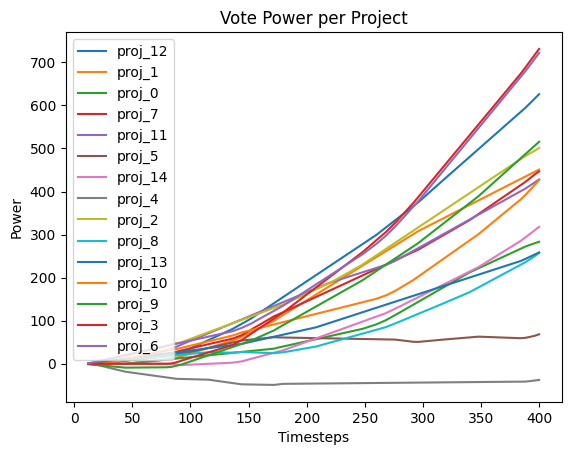

In [11]:
# Per project metrics

per_proj_votes = sim_df.per_project_voting.apply(pd.Series).dropna()
per_proj_votes.plot(title='Vote Power per Project', xlabel='Timesteps', ylabel='Power')
plt.show()